# Predicting Student Wait Time at LAIR for Stanford’s Introductory Computer Science Courses

## Project Group:
Sachin Allums (sachino)\
Justin Blumencranz (jmb25)\
Andrew Hong (amhong)\
Mahathi Mangipudi (mahathim)

Stanford enrolls over 2500 students each year in its two introductory computer science courses: CS106A and CS106B. These students have the opportunity to make use of LaIR, a space where they can receive one-on-one help from a section leader with their code for a given assignment. Currently, section leaders of the course are recommended to spend 15 minutes on each help request to better manage the flow of assistance. The purpose of our project is to develop a model that can predict how long students have to wait to receive help based on the assignment they are completing, the time they go to LaIR, and the number of days they go before the assignment deadline, among other features. 

## Model Selection

We have chosen to implement a linear regression model, which will take in a variety of features describing the context of a single LaIR request and output an estimated wait time for the student to recieve help.

***

# Import Packages
Here we import all of the libraries/packages we will need to train and analyze our model

In [29]:
# import tensorflow as tf
# from tensorflow import keras
# from keras.models import Sequential
# from keras.layers import Dense
# from tensorflow.keras import regularizers
# from tensorflow.keras.layers import LayerNormalization
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import copy, math
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from matplotlib.ticker import MaxNLocator


from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.ensemble import GradientBoostingRegressor

# Make NumPy printouts easier to read.
np.set_printoptions(precision=3, suppress=True)

# Pre-Training Steps

Below are the neccesary functions to load in the data from our dataset

In [30]:
'''
A class for storing subsets of the entire dataset as a pandas DataFrame
'''
class Dataset:
    def __init__(self, dataframe, label_column):
        self.dataframe = dataframe
        self.label_column = label_column
        self.features = dataframe.drop(label_column, axis=1)
        self.labels = dataframe[[label_column]]
        
    def to_numpy(self):
        X = self.features.to_numpy()
        y = self.labels.to_numpy().ravel()
        return X, y
    
    def features_to_numpy(self):
        return self.features.to_numpy()
    
    def labels_to_numpy(self):
        return self.labels.to_numpy().ravel()
    
    def get_feature_names(self):
        return self.features.columns.tolist()
    
    def get_label_name(self):
        return self.label_column
    
    def __len__(self):
        return len(self.dataframe)
    
    def display_head(self, n=5):
        return (self.dataframe.head(n)
                .style
                .format("{:.2f}")
                .set_table_styles([{'selector': 'tr:hover',
                                    'props': [('background-color', '#ffff99')]}]))
    
    def column_to_numpy(self, column_name):
        """Retrieve a specific column by name as a NumPy array."""
        if column_name in self.dataframe.columns:
            return self.dataframe[column_name].to_numpy()
        else:
            raise ValueError(f"Column {column_name} does not exist in the dataset.")

    def get_column_by_name(self, column_name):
            """
            Retrieve a specific column by name. This method returns the column
            as a pandas Series. If the column is the label, it returns the label
            column; otherwise, it searches among the features.
            """
            if column_name == self.label_column:
                return self.labels
            elif column_name in self.features.columns:
                return self.features[column_name]
            else:
                raise ValueError(f"Column '{column_name}' not found in the dataset.")


In [31]:
def split_dataset(filepath, included_columns, label_column):
    # Load dataset from filepath
    df = pd.read_csv(filepath)

    # Convert all cells to floats
    for column in df.columns:
        df[column] = pd.to_numeric(df[column], errors='coerce')

    # Include only the columns specified
    df = df[included_columns]
    
    # Split the data
    train, test = train_test_split(df, test_size=1-TRAIN_SIZE)
    test, cv = train_test_split(test, test_size=TEST_SIZE/(1-TRAIN_SIZE))

    # Create Dataset instances
    TRAIN = Dataset(train, label_column)
    CV = Dataset(cv, label_column)
    TEST = Dataset(test, label_column)
    
    # Print Split Sizes
    print(f"Total number of examples: {len(df)}")
    print(f"Sizes of TRAIN, CV, TEST: [{len(TRAIN)},{len(CV)},{len(TEST)}]")

    return TRAIN, CV, TEST


# Training Utility Functions: Linear Regression
Below are the functions used to train the model using gradient decent with MSE cost.

In [32]:
def compute_cost(X, y, w, b, lambda_=0): 
    """
    compute cost
    Args:
      X (ndarray (m,n)): Data, m examples with n features
      y (ndarray (m,)) : target values
      w (ndarray (n,)) : model parameters  
      b (scalar)       : model parameter
      
    Returns:
      cost (scalar): cost
    """
    m = X.shape[0]
    f_wb = (X @ w) + b
    error = (f_wb - y)
    regularization = (lambda_ / m) * (w @ w)
    return ((error @ error) / (2 * m)) + regularization

In [33]:
def compute_gradient(X, y, w, b, lambda_=0): 
    """
    Computes the gradient for linear regression 
    Args:
      X (ndarray (m,n)): Data, m examples with n features
      y (ndarray (m,)) : target values
      w (ndarray (n,)) : model parameters  
      b (scalar)       : model parameter
      
    Returns:
      dj_dw (ndarray (n,)): The gradient of the cost w.r.t. the parameters w. 
      dj_db (scalar):       The gradient of the cost w.r.t. the parameter b. 
    """
    m = X.shape[0]
    error = (X @ w) + b - y
    dj_dw = ((X.T @ error) + (lambda_ * w)) / m
    dj_db = np.sum(error) / m
    return dj_db, dj_dw 

In [34]:
def gradient_descent(X, y, X_cv, y_cv, w_in, b_in, cost_function, gradient_function, alpha, num_iters, lambda_, silent=False): 
    """
    Performs batch gradient descent to learn w and b. Updates w and b by taking 
    num_iters gradient steps with learning rate alpha
    
    Args:
      X (ndarray (m,n))   : Data, m examples with n features
      y (ndarray (m,))    : target values
      X_cv                : Data, m examples with n features (from CV used to compute J_cv for learning curves)
      y_cv                : target values                    (from CV used to compute J_cv for learning curves)
      w_in (ndarray (n,)) : initial model parameters  
      b_in (scalar)       : initial model parameter
      cost_function       : function to compute cost
      gradient_function   : function to compute the gradient
      alpha (float)       : Learning rate
      num_iters (int)     : number of iterations to run gradient descent
      
    Returns:
      w (ndarray (n,)) : Updated values of parameters 
      b (scalar)       : Updated value of parameter 
      """
    
    # An array to store cost J and w's at each iteration primarily for graphing later
    J_train_history = []
    J_cv_history = []
    w = copy.deepcopy(w_in)  #avoid modifying global w within function
    b = b_in
    
    for i in range(num_iters):

        # Calculate the gradient and update the parameters
        dj_db,dj_dw = gradient_function(X, y, w, b)   ##None

        # Update Parameters using w, b, alpha and gradient
        w = w - alpha * dj_dw               ##None
        b = b - alpha * dj_db               ##None
      
        # Save cost J at each iteration
        if i<100000:      # prevent resource exhaustion 
            J_train_history.append( cost_function(X, y, w, b, lambda_=0)) # Don't Regularize When Evaluating
            J_cv_history.append( cost_function(X_cv, y_cv, w, b, lambda_=0))

        # Print cost every at intervals 10 times or as many iterations if < 10
        if i% math.ceil(num_iters / 10) == 0:
            if not silent: print(f"Iteration {i:4d}: Cost {J_train_history[-1]:8.2f}   ")
        
    return w, b, J_train_history, J_cv_history #return final w,b and J history for graphing

In [35]:
def predict(x, w, b): 
    """
    single predict using linear regression
    Args:
      x (ndarray): Shape (n,) example with multiple features
      w (ndarray): Shape (n,) model parameters   
      b (scalar):             model parameter 
      
    Returns:
      p (scalar):  prediction
    """
    return (x @ w) + b      

In [36]:
def train_linear_regression(X, y, X_cv, y_cv, return_history=True, silent=False):
    m, n = X.shape

    # Step 1: Initialize Parameters
    w = W_INIT(n)                          # Calls lambda W_INIT to populate w with n weights
    b = B_INIT                             # Scalar quantity
    iterations = ITERATIONS
    alpha = LEARNING_RATE
    lambda_ = LAMBDA

    # Step 2: Show Cost Pre-Training
    initial_cost = compute_cost(X, y, w, b)
    if not silent: print(f"Initial Cost: {initial_cost}")


#     # Step 3: Show Gradiant Pre-Training
#     tmp_dj_db, tmp_dj_dw = compute_gradient_regularized(X, y, w, b)
#     print(f'dj_db at initial w,b: {tmp_dj_db}')
#     print(f'dj_dw at initial w,b: \n {tmp_dj_dw}')

    # Step 4: Run Gradient Decent
    w_final, b_final, J_train_hist, J_cv_hist = gradient_descent(X, y, X_cv, y_cv, w, b,
                                                    compute_cost, compute_gradient, 
                                                    alpha, iterations, lambda_, silent=silent)
#    print(f"w, b found by gradient descent:\nw= {w_final}\nb= {b_final:0.2f}")

    if not silent: print("Finished Running Gradient Descent")

    # Step 5: Print a few predictions
    num_shown_predictions = 5
    for i in range(num_shown_predictions):
        if not silent: print(f"prediction: {np.dot(X[i], w_final) + b_final:0.2f}, target value: {y[i]}")
    
    # Step 6: Return trained weights and bias
    if return_history: return w_final, b_final, J_train_hist, J_cv_hist
    else: return w_final, b_final

# Analysis Utility Functions
Below are functions used to analyze the performance of the model on the split dataset

In [37]:
def compute_baseline_estimates(dataset):
    # Get columns for numInQueue and TAsPerSession to do naive estimation
    numInQueue = dataset.column_to_numpy('numInQueue')
    TAsPerSession = dataset.column_to_numpy('TAsPerSession')

    # Replace zeros with average number of SLs which is 17
    # TAsPerSession = np.nan_to_num(TAsPerSession, nan=17)

    # print(f"numInQueue looks like:\n{numInQueue}\n")
    # print(f"TAsPerSession looks like:\n{TAsPerSession}\n")
    
    # Expected minutes until active TAs finish their current request (assuming uniform distribution from 0-15 minutes)
    expected_time_into_session = 7.5

    # Assuming the total remaining current session time is the same for each queue entry, as it's a fixed value based on our assumptions
    total_remaining_current_session_time = expected_time_into_session

    # Total rounds of Section Leader help needed to help everyone in the queue, calculated for the entire array at once
    total_rounds = np.ceil(numInQueue / TAsPerSession)

    # Time for the queue is rounds times the average session length (making the naive assumption that each round takes 15 minutes)
    total_time_for_queue = total_rounds * 15

    # Estimated wait time is time to finish current sessions + time to get through the queue, for the entire array at once
    estimated_wait_times = total_remaining_current_session_time + total_time_for_queue

    return estimated_wait_times

In [38]:
def baseline_cost(y_baseline, y, lambda_=0):
    """
    compute cost
    Args:
      y_baseline (ndarray (m,)) : baseline predictions
      y (ndarray (m,))          : target values
      lambda_ (scalar)          : regularization constant
      
    Returns:
      cost (scalar): cost
    """
    m = y_baseline.shape[0]
    
    error = (y_baseline - y)
    regularization = (lambda_ / m) * (w @ w)
    return (error @ error) / (2 * m) + regularization

In [39]:
def predicted_mean_error(X, y, w, b):
    """
    Computes the absolute errors between the predictions and the true labels for each example.

    Parameters:
    - dataset: Dataset storing inputs and labels for a given split of the full dataset
    - w: Weight vector (n features by 1)
    - b: Bias term (scalar)

    Returns:
    - errors: Absolute errors (m examples by 1)
    """
    # X = np.nan_to_num(X)

    predictions = predict(X, w, b)
    errors = np.abs(predictions - y)
    return np.mean(errors)

In [40]:
def baseline_mean_error(dataset):
    y = dataset.labels_to_numpy()
    predictions = compute_baseline_estimates(dataset)
    
    errors = np.abs(predictions - y)
    return np.mean(errors)

In [41]:
def forest_mean_error(X, y, regressor):
    predictions = regressor.predict(X)
    mae = mean_absolute_error(y, predictions)
    print(f"Mean Absolute Error: {mae}")
    return mae

# Second Baseline: Random Forest

In [42]:
def train_random_forest(X_train, y_train):
    regressor = RandomForestRegressor(n_estimators=100, random_state=42)
    regressor.fit(X_train, y_train)
    print("Done!")
    return regressor

In [43]:
def train_random_forest_XG_boost(X_train, y_train):
    regressor = GradientBoostingRegressor(n_estimators=100, random_state=42)
    regressor.fit(X_train, y_train)
    print("Done!")
    return regressor

# Plotting Utility Functions

In [44]:
def plot_learning_curves(J_train_history, J_cv_history, J_baseline, tail_fraction=0.2):
    """
    Plot learning curves for training and cross-validation sets, along with a baseline cost.
    
    Parameters:
    - J_train_history: List of training set costs.
    - J_cv_history: List of cross-validation set costs.
    - J_baseline: A single number representing a baseline cost to plot as a horizontal line.
    - tail_fraction: The fraction of the data from the end to plot in a separate graph. Default is 0.2.
    """
    iterations = range(1, len(J_train_history) + 1)
    tail_size = int(len(J_train_history) * tail_fraction)
    
    # Main plot
    plt.figure(figsize=(10, 6))
    plt.plot(iterations, J_train_history, label='J_train', color='blue')
    plt.plot(iterations, J_cv_history, label='J_cv', color='lime')
    plt.axhline(y=J_baseline, color='red', linestyle='-', label='Baseline Cost')
    plt.xlabel('Iterations')
    plt.ylabel('Cost')
    plt.legend()
    plt.title('Learning Curves')
    plt.savefig('learning-curve.png', dpi=300)
    plt.show()
    
    # Tail plot
    if tail_size > 0:
        plt.figure(figsize=(10, 6))
        plt.plot(iterations[-tail_size:], J_train_history[-tail_size:], label='J_train Tail', color='blue')
        plt.plot(iterations[-tail_size:], J_cv_history[-tail_size:], label='J_cv Tail', color='lime')
        plt.axhline(y=J_baseline, color='red', linestyle='-', label='Baseline Cost')
        plt.xlabel('Iterations (Tail)')
        plt.ylabel('Cost')
        plt.legend()
        plt.title('Learning Curves (Tail)')
        plt.savefig('learning-curve-tail.png', dpi=300)
        plt.show()


In [59]:
def plot_mean_errors(naive_values, predicted_values, forest_values, xg_values, labels=['TRAIN', 'CV', 'TEST']):
    """
    Plot NAIVE, PREDICTED, and FOREST mean error values for TRAIN, CV, and TEST datasets as a bar graph.

    Parameters:
    - naive_values: List of NAIVE mean error values for each dataset.
    - predicted_values: List of PREDICTED mean error values for each dataset.
    - forest_values: List of FOREST mean error values for each dataset.
    - labels: Labels for the datasets (default is ['TRAIN', 'CV', 'TEST']).
    """
    
    # Number of dataset categories
    n = len(labels)

    # X positions for the groups
    index = np.arange(n)

    # Bar width (adjusted to fit the third bar)
    bar_width = 0.15

    # Opacity for the bars
    opacity = 0.8

    # Plotting Naive values
    plt.bar(index, naive_values, bar_width, alpha=opacity, color='#4169e1', label='Naive')

    # Plotting Prediction values
    plt.bar(index + bar_width, predicted_values, bar_width, alpha=opacity, color='#dc143c', label='Prediction')

    # Plotting Forest values
    plt.bar(index + 2*bar_width, forest_values, bar_width, alpha=opacity, color='#2e8b57', label='Forest')

    # Plotting XGBoost values
    plt.bar(index + 3*bar_width, xg_values, bar_width, alpha=opacity, color='#800080', label='XGBoost')


    # Add title and axis labels
    plt.title('Comparison of Baseline, Predicted, Forest, and XGBoost Mean Errors')
    plt.xlabel('Dataset')
    plt.ylabel('MAE')
    plt.xticks(index + bar_width, labels)  # Adjusting positioning of dataset labels for 3 bars

    # Adding a legend
    plt.legend()

    # Optional: Add a grid
    plt.grid(True, linestyle='--')

    # Show plot
    plt.tight_layout()
    plt.savefig('mean-errors.png', dpi=300)
    plt.show()

In [60]:
def histogram(data, title="Title", x_label="X Label", y_label="Y Label"):
    plt.figure(figsize=(10, 6))  # Optional: specify the figure size
    plt.hist(data, bins=30, alpha=0.75, color='blue', edgecolor='black')  # Plot histogram
    
    plt.title(title)  # Title of the histogram
    plt.xlabel(x_label)  # X-axis label
    plt.ylabel(y_label)  # Y-axis label
    
    plt.grid(False)  # Show grid
    plt.show()  # Display the histogram

# Training
Here we will load the dataset and train the model by calling our utility functions

In [61]:
### MODEL CONTROL PANEL ###

# Filepath to Dataset
FILEPATH = "FINAL.csv"

# Define split sizes
TRAIN_SIZE = 0.8
CV_SIZE = 0.1
TEST_SIZE = 0.1

# Model hyperparameters
LEARNING_RATE = 0.04
ITERATIONS = 5000
LAMBDA = 0                                                       # 0 For no regularization
B_INIT = 0
W_INIT = lambda n_features: np.random.uniform(-1, 1, n_features)

# Which Columns are Features
INCLUDED_COLUMNS = [
  "waitTime",
  "numInQueue",
  "sessionTime",
  "hoursToDeadline",
  "signUpTimeClean",
  "bitAndKarel",
  "imagesAndGraphics",
  "mapsAndDictionaries",
  "lambdas",
  "fileReading",
  "grids",
  "strings",
  "userInteraction",
  "queuesAndStacks",
  "recursion",
  "structs",
  "objectOrientedProgramming",
  "pointersAndMemory",
  "sorting",
  "hashTables",
  "CS106ABinary",
  "TAsPerSession"
]
# Which Column is the label
Y_LABEL = "waitTime"


### Don't Touch Anything Below This Line ##################################
assert TRAIN_SIZE + CV_SIZE + TEST_SIZE == 1 # Ensure splits add up to 100%
assert TRAIN_SIZE > 0
assert CV_SIZE > 0
assert TEST_SIZE > 0
assert len(INCLUDED_COLUMNS) > 0
assert LEARNING_RATE > 0

In [62]:
# Step 1: Load and split dataset
TRAIN, CV, TEST = split_dataset(FILEPATH, INCLUDED_COLUMNS, Y_LABEL)

Total number of examples: 19031
Sizes of TRAIN, CV, TEST: [15224,1904,1903]


In [63]:
# Step 2: Print out a few of the training examples
TRAIN.display_head()

,waitTime,numInQueue,sessionTime,hoursToDeadline,signUpTimeClean,bitAndKarel,imagesAndGraphics,mapsAndDictionaries,lambdas,fileReading,grids,strings,userInteraction,queuesAndStacks,recursion,structs,objectOrientedProgramming,pointersAndMemory,sorting,hashTables,CS106ABinary,TAsPerSession
17279,2.00,6.00,0.02,94.00,66667.00,0.00,1.00,1.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,20.00
16372,8.00,4.00,0.01,50.73,66667.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,8.00
14603,2.00,0.00,0.03,38.72,88889.00,0.00,0.00,1.00,0.00,1.00,1.00,0.00,1.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,23.00
18462,8.00,1.00,0.01,52.80,55556.00,0.00,1.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,21.00
10077,10.00,11.00,0.02,314.33,33333.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,14.00


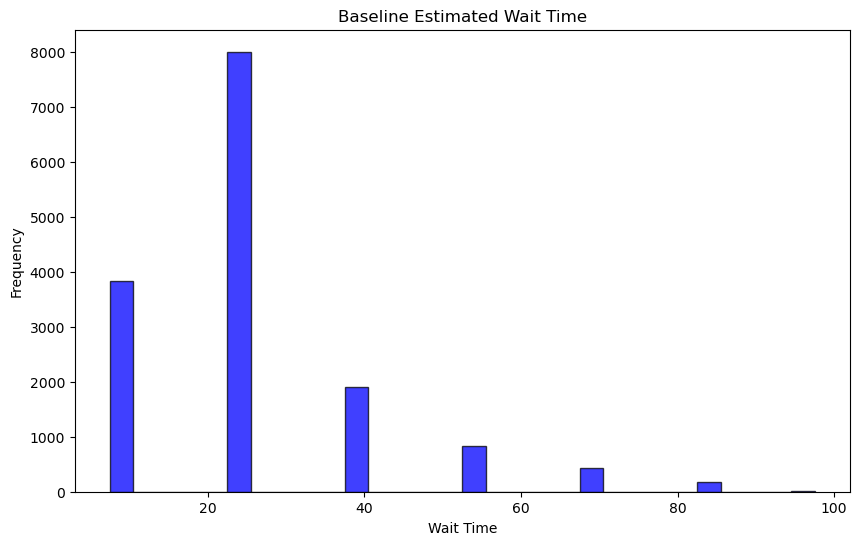

In [64]:
# Step 3: Compute baseline estimate of wait time (before normalization occurs)
y_baseline = compute_baseline_estimates(TRAIN)
histogram(y_baseline, title="Baseline Estimated Wait Time", x_label="Wait Time", y_label="Frequency")

In [65]:
# Pull out training and cv data
X_train = TRAIN.features_to_numpy()
y_train = TRAIN.labels_to_numpy()

X_cv = CV.features_to_numpy()
y_cv = CV.labels_to_numpy()

# X_train = np.nan_to_num(X_train)
# X_cv = np.nan_to_num(X_cv)

# Fit StandardScaler to training data for normalization
scaler = preprocessing.StandardScaler()
scaler.fit(X_train)

# Scale Features
X_train_scaled = scaler.transform(X_train)
X_cv_scaled = scaler.transform(X_cv)

In [66]:
# Train Linear Regression Model
w, b, J_train_hist, J_cv_hist = train_linear_regression(X_train_scaled, y_train, X_cv_scaled, y_cv, return_history=True)

Initial Cost: 385.7900320418262
Iteration    0: Cost   360.66   
Iteration  500: Cost    85.95   
Iteration 1000: Cost    85.93   
Iteration 1500: Cost    85.92   
Iteration 2000: Cost    85.92   
Iteration 2500: Cost    85.91   
Iteration 3000: Cost    85.91   
Iteration 3500: Cost    85.91   
Iteration 4000: Cost    85.90   
Iteration 4500: Cost    85.90   
Finished Running Gradient Descent
prediction: 15.07, target value: 2
prediction: 13.55, target value: 8
prediction: 4.93, target value: 2
prediction: 3.66, target value: 8
prediction: 18.39, target value: 10


In [67]:
# Train Random Forest
random_forest_regressor = train_random_forest(X_train_scaled, y_train)

Done!


In [68]:
random_forest_regressor_xg_boost = train_random_forest_XG_boost(X_train_scaled, y_train)

Done!


# Fine Tuning

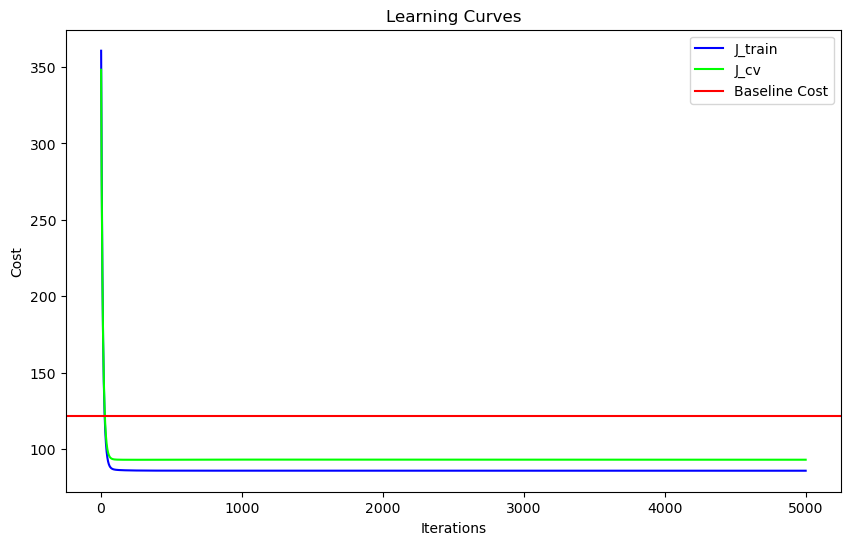

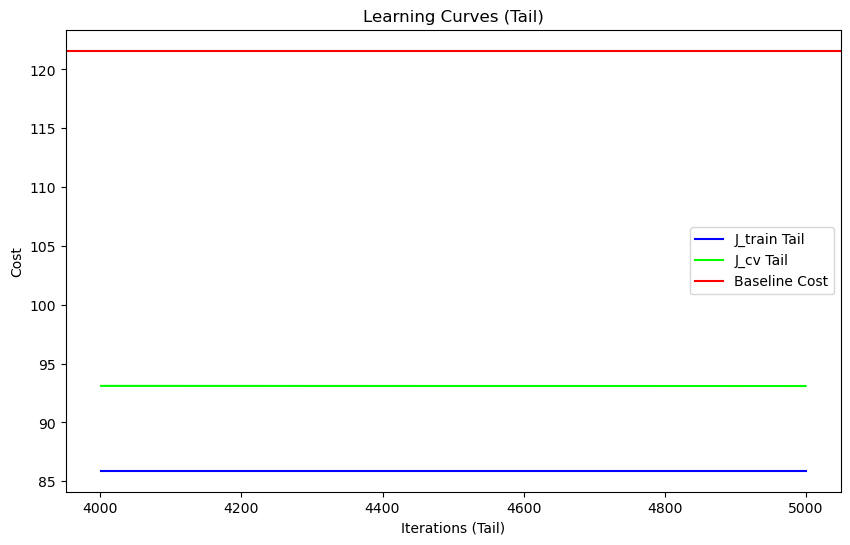

In [69]:
# Plot Learning Curves for J_train and J_cv to diagnose bias and variance
J_baseline = baseline_cost(y_baseline, y_train)
plot_learning_curves(J_train_hist, J_cv_hist, J_baseline)

In [70]:
# # Trying different lambda values, pick the one that minimizes J_cv
# J_cv = []
# lambda_old = LAMBDA
# min_lambda = 0
# max_lambda = 100
# step_size = 1
# for test_lambda in np.arange(min_lambda, max_lambda, step_size):
#     print(f"Testing lambda={test_lambda}")
#     LAMBDA = test_lambda
#     w_trash, b_trash, J_train_hist, J_cv_hist = train_linear_regression(X_train_scaled, y_train, X_cv_scaled, y_cv, return_history=True, silent=True)
#     J_cv.append(J_cv_hist[-1])

# LAMBDA = lambda_old

# plt.figure(figsize=(10, 6))  # Optional: Specifies the figure size
# plt.plot(np.arange(min_lambda, max_lambda, step_size), J_cv, marker='o')  # Plot the points with markers

# # Set x-axis major locator to integer values
# ax = plt.gca()  # Get the current Axes instance
# ax.xaxis.set_major_locator(MaxNLocator(integer=True))

# plt.title('Lambda v. Final J_cv')  # Optional: Adds a title to the plot
# plt.xlabel('Lambda')  # Optional: Adds a label to the X axis
# plt.ylabel('J_cv')  # Optional: Adds a label to the Y axis
# plt.grid(True)  # Optional: Shows a grid
# plt.savefig('lambda-v-jcv.png', dpi=300)
# plt.show()

# print(f"Minimum Value of Lambda: {np.arange(min_lambda, max_lambda, step_size)[np.argmin(J_cv)]}")

In [71]:
# # Trying different learning rates values, pick the one that minimizes J_cv
# J_cv = []
# alpha_old = LEARNING_RATE
# min_alpha = 0.001
# max_alpha = 0.1
# step_size = 0.001
# for test_alpha in np.arange(min_alpha, max_alpha, step_size):
#     print(f"Testing alpha={test_alpha}")
#     LEARNING_RATE = test_alpha
#     w_trash, b_trash, J_train_hist, J_cv_hist = train_linear_regression(X_train_scaled, y_train, X_cv_scaled, y_cv, return_history=True, silent=True)
#     J_cv.append(J_cv_hist[-1])

# LEARNING_RATE = alpha_old

# plt.figure(figsize=(10, 6))  # Optional: Specifies the figure size
# plt.plot(np.arange(min_alpha, max_alpha, step_size), J_cv, marker='o')  # Plot the points with markers

# plt.title('Alpha v. Final J_cv')  # Optional: Adds a title to the plot
# plt.xlabel('Alpha')  # Optional: Adds a label to the X axis
# plt.ylabel('J_cv')  # Optional: Adds a label to the Y axis
# plt.grid(True)  # Optional: Shows a grid
# plt.savefig('alpha-v-jcv.png', dpi=300)
# plt.show()

# print(f"Minimum Value of Alpha: {np.arange(min_alpha, max_alpha, step_size)[np.argmin(J_cv)]}")

# Analysis
A comparison of the different algorithms using a mean absolute error cost function

Mean Absolute Error: 2.006388708774366
Mean Absolute Error: 6.443000199909915
Mean Absolute Error: 5.496314121481927
Mean Absolute Error: 6.8050911697275795
Mean Absolute Error: 4.961945220161983
Mean Absolute Error: 6.369593575640783


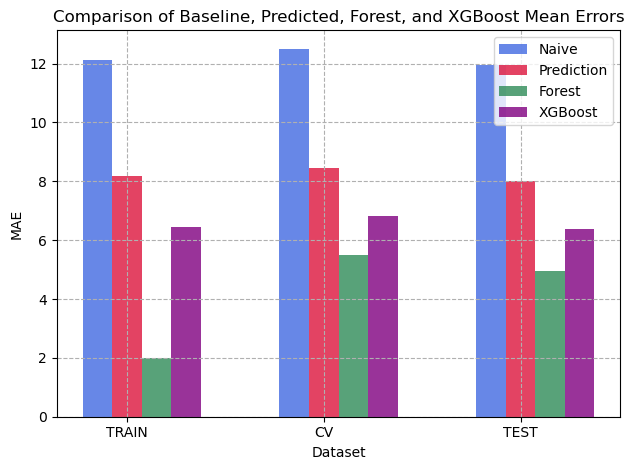

Improvement on Train from Bassline: 32.45%
Improvement on CV from Bassline: 32.35%
Improvement on Test  from Bassline: 33.13%
11.966106148187073
8.001847296482513
4.961945220161983
6.369593575640783


In [72]:
# MAE assuming optimal conditions (every request takes 15 minutes and all SLs take new requests immediately after finishing their current request)
mae_naive = [baseline_mean_error(split) for split in [TRAIN, CV, TEST]]

# MAE taken from the model's predictions
mae_prediction = []

# MAE taken from random forest predictions
mae_forest = []

# MAE taken from the XG boos predictions
mae_xg_boost = []

for split in [TRAIN, CV, TEST]:
    X = split.features_to_numpy()
    X_scaled = scaler.transform(X)
    # X_scaled = np.nan_to_num(X_scaled)
    y = split.labels_to_numpy()
    mae_prediction.append(predicted_mean_error(X_scaled, y, w, b))
    mae_forest.append(forest_mean_error(X_scaled, y, random_forest_regressor))
    mae_xg_boost.append(forest_mean_error(X_scaled, y, random_forest_regressor_xg_boost))

# Plot bars for each set
plot_mean_errors(mae_naive, mae_prediction, mae_forest, mae_xg_boost, labels=['TRAIN', 'CV', 'TEST'])

print(f"Improvement on Train from Bassline: {(-1*((mae_prediction[0] - mae_naive[0]) / mae_naive[0]) * 100):0.2f}%")
print(f"Improvement on CV from Bassline: {(-1*((mae_prediction[1] - mae_naive[1]) / mae_naive[1]) * 100):0.2f}%")
print(f"Improvement on Test  from Bassline: {(-1*((mae_prediction[2] - mae_naive[2]) / mae_naive[2]) * 100):0.2f}%")


print(mae_naive[-1])
print(mae_prediction[-1])
print(mae_forest[-1])
print(mae_xg_boost[-1])